# Group level RSA

In [1]:
import numpy as np

subjects = ['subj02', 'subj03', 'subj04', 'subj05', 'subj07', 'subj08', 'subj09', 'subj10', 'subj11', 'subj12', 'subj13', 'subj14', 'subj15', 'subj16', 'subj17', 'subj19',
            'subj20', 'subj21', 'subj22', 'subj23',  'subj24',  'subj25',  'subj26',  'subj27',  'subj28',  'subj29',  'subj31',  'subj32',  'subj33',  'subj34',  'subj35',
              'subj38',  'subj39',  'subj40']
data_dir = '.'  # 如果 group notebook 跟資料夾在同一層，否則填正確路徑

In [2]:
rsa_correctness_allsubs = []
rsa_clarity_allsubs = []
rsa_hemifield_allsubs = []
time_centers = None

for subj in subjects:
    rsa_correctness = np.load(f"{data_dir}/{subj}/rsa_correctness.npy")
    rsa_clarity = np.load(f"{data_dir}/{subj}/rsa_clarity.npy")
    rsa_hemifield = np.load(f"{data_dir}/{subj}/rsa_hemifield.npy")
    # 只要第一位 subject 的時間軸即可
    if time_centers is None:
        time_centers = np.load(f"{data_dir}/{subj}/time_centers_trialwise.npy")
    rsa_correctness_allsubs.append(rsa_correctness)
    rsa_clarity_allsubs.append(rsa_clarity)
    rsa_hemifield_allsubs.append(rsa_hemifield)

rsa_correctness_allsubs = np.stack(rsa_correctness_allsubs)
rsa_clarity_allsubs = np.stack(rsa_clarity_allsubs)
rsa_hemifield_allsubs = np.stack(rsa_hemifield_allsubs)

FileNotFoundError: [Errno 2] No such file or directory: './subj14/rsa_correctness.npy'

In [ ]:
import matplotlib.pyplot as plt

def plot_group_rsa(time_centers, rsa_allsubs, label):
    mean = np.mean(rsa_allsubs, axis=0)
    sem = np.std(rsa_allsubs, axis=0, ddof=1) / np.sqrt(rsa_allsubs.shape[0])
    plt.plot(time_centers * 1000, mean, label=label)
    plt.fill_between(time_centers * 1000, mean - sem, mean + sem, alpha=0.3)

plt.figure(figsize=(12, 5))
plot_group_rsa(time_centers, rsa_correctness_allsubs, 'Correctness')
plot_group_rsa(time_centers, rsa_clarity_allsubs, 'Clarity')
plot_group_rsa(time_centers, rsa_hemifield_allsubs, 'Hemifield')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('RSA Score (Spearman r)')
plt.title('Group-level RSA (mean ± SEM, n=5)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import ttest_1samp
import plotly.graph_objs as go
import ipywidgets as widgets

# 假設已經有三個 allsubs array 和 time_centers
rsa_dict = {
    "Correctness": rsa_correctness_allsubs,
    "Clarity": rsa_clarity_allsubs,
    "Hemifield": rsa_hemifield_allsubs
}

# 統整各類型 mean、sem、顯著點
group_rsa_summary = {}
for k, arr in rsa_dict.items():
    mean = np.mean(arr, axis=0)
    sem = np.std(arr, axis=0, ddof=1) / np.sqrt(arr.shape[0])
    tvals, pvals = ttest_1samp(arr, 0, axis=0)
    sig_mask = pvals < 0.05
    group_rsa_summary[k] = {
        "mean": mean,
        "sem": sem,
        "sig_mask": sig_mask
    }

def plot_interactive_group_rsa(time_points, group_rsa_summary):
    dropdown = widgets.Dropdown(
        options=list(group_rsa_summary.keys()),
        value=list(group_rsa_summary.keys())[0],
        description='Behavior RDM:'
    )

    def update_plot(rdm_name):
        mean = group_rsa_summary[rdm_name]["mean"]
        sem = group_rsa_summary[rdm_name]["sem"]
        sig_mask = group_rsa_summary[rdm_name]["sig_mask"]

        fig = go.Figure()
        # 畫 group mean
        fig.add_trace(go.Scatter(
            x=time_points,
            y=mean,
            mode='lines+markers',
            name='Group Mean',
            line=dict(width=3)
        ))
        # 畫 ±SEM 帶狀
        fig.add_trace(go.Scatter(
            x=np.concatenate([time_points, time_points[::-1]]),
            y=np.concatenate([mean - sem, (mean + sem)[::-1]]),
            fill='toself',
            fillcolor='rgba(0,150,255,0.15)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='±SEM'
        ))
        # 顯著點（p<.05）
        if np.any(sig_mask):
            fig.add_trace(go.Scatter(
                x=time_points[sig_mask],
                y=mean[sig_mask],
                mode='markers',
                marker=dict(color='red', size=7),
                name='p < .05'
            ))

        fig.update_layout(
            title=f"Group-level RSA for {rdm_name}",
            xaxis_title="Time (s)",
            yaxis_title="RSA (Spearman correlation)",
            width=900, height=400,
            template="simple_white"
        )
        fig.show()

    widgets.interact(update_plot, rdm_name=dropdown)

# 呼叫（time_centers單位如需ms/秒可自行處理）
plot_interactive_group_rsa(time_centers, group_rsa_summary)

print("✅ 完成 group-level RSA 互動式可視化！")

# Cluster-based Permutation Test

In [ ]:
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_1samp_test
import numpy as np

plt.figure(figsize=(14, 6))

for rdm_name, X in rsa_dict.items():
    print(f"=== {rdm_name} ===")
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
        X, n_permutations=1000, threshold=None, tail=0, n_jobs=1, out_type='mask'
    )
    mean = np.mean(X, axis=0)
    # 印出所有 cluster p-value 與時間範圍
    for i_c, c in enumerate(clusters):
        c = c[0]  # boolean mask (n_times,)
        tmin = time_centers[c].min() * 1000 if np.any(c) else None
        tmax = time_centers[c].max() * 1000 if np.any(c) else None
        print(f"  cluster {i_c+1}: p={cluster_p_values[i_c]:.4f}, t=[{tmin}, {tmax}] ms, n_points={np.sum(c)}")
        if cluster_p_values[i_c] < 0.05 and np.any(c):
            # 畫 shaded
            plt.axvspan(tmin, tmax,
                        color=colors[rdm_name], alpha=0.18, lw=0)
            # 取 shaded 區間的中心
            x_text = (tmin + tmax) / 2
            y_text = mean[c].max() + 0.02  # p-value 標在 shaded 上方
            plt.text(x_text, y_text, f"p={cluster_p_values[i_c]:.3f}",
                     ha='center', va='bottom', fontsize=11, color=colors[rdm_name], fontweight='bold')
    plt.plot(time_centers * 1000, mean, label=rdm_name, color=colors[rdm_name], linewidth=2)

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('RSA Score (Spearman r)')
plt.title('Group-level RSA: Cluster-based Permutation Test (shaded: p<.05, p-value shown)')
plt.legend()
plt.tight_layout()
plt.show()

# Group level RSA pca

In [6]:
import numpy as np

subjects = ['subj02', 'subj03', 'subj04', 'subj05', 'subj07', 'subj08', 'subj09', 'subj10', 'subj11', 'subj12', 'subj13', 'subj14', 'subj15', 'subj16', 'subj17', 'subj19',
            'subj20', 'subj21', 'subj22', 'subj23',  'subj24',  'subj25',  'subj26',  'subj27',  'subj28',  'subj29',  'subj31',  'subj32',  'subj33',  'subj34',  'subj35',
              'subj38',  'subj39',  'subj40']
data_dir = '.'  # 如果 group notebook 跟資料夾在同一層，否則填正確路徑

In [7]:
rsa_correctness_allsubs = []
rsa_clarity_allsubs = []
rsa_hemifield_allsubs = []
time_centers = None

for subj in subjects:
    rsa_correctness = np.load(f"{data_dir}/{subj}/rsa_correctness_pca.npy")
    rsa_clarity = np.load(f"{data_dir}/{subj}/rsa_clarity_pca.npy")
    rsa_hemifield = np.load(f"{data_dir}/{subj}/rsa_hemifield_pca.npy")
    # 只要第一位 subject 的時間軸即可
    if time_centers is None:
        time_centers = np.load(f"{data_dir}/{subj}/time_centers_trialwise.npy")
    rsa_correctness_allsubs.append(rsa_correctness)
    rsa_clarity_allsubs.append(rsa_clarity)
    rsa_hemifield_allsubs.append(rsa_hemifield)

rsa_correctness_allsubs = np.stack(rsa_correctness_allsubs)
rsa_clarity_allsubs = np.stack(rsa_clarity_allsubs)
rsa_hemifield_allsubs = np.stack(rsa_hemifield_allsubs)

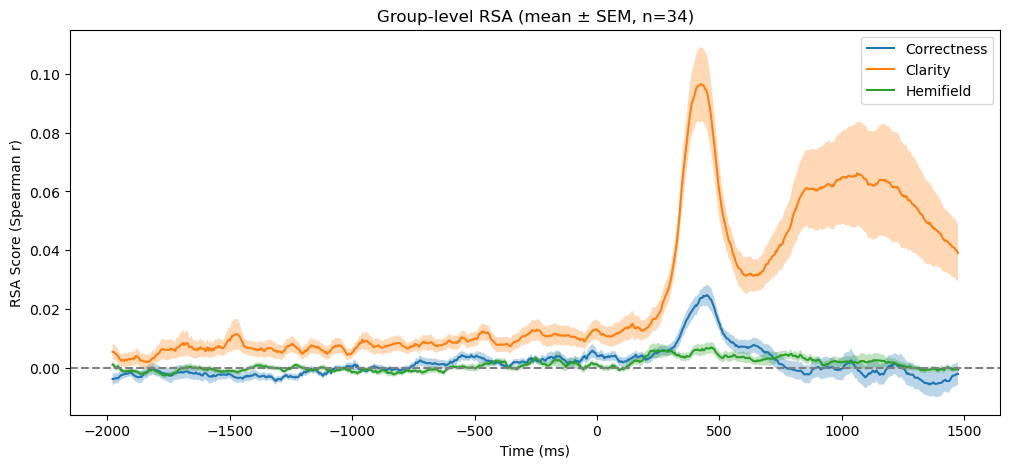

In [10]:
import matplotlib.pyplot as plt

def plot_group_rsa(time_centers, rsa_allsubs, label):
    mean = np.mean(rsa_allsubs, axis=0)
    sem = np.std(rsa_allsubs, axis=0, ddof=1) / np.sqrt(rsa_allsubs.shape[0])
    plt.plot(time_centers * 1000, mean, label=label)
    plt.fill_between(time_centers * 1000, mean - sem, mean + sem, alpha=0.3)

plt.figure(figsize=(12, 5))
plot_group_rsa(time_centers, rsa_correctness_allsubs, 'Correctness')
plot_group_rsa(time_centers, rsa_clarity_allsubs, 'Clarity')
plot_group_rsa(time_centers, rsa_hemifield_allsubs, 'Hemifield')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('RSA Score (Spearman r)')
plt.title('Group-level RSA (mean ± SEM, n=34)')
plt.legend()
plt.show()

In [11]:
import numpy as np
from scipy.stats import ttest_1samp
import plotly.graph_objs as go
import ipywidgets as widgets

# 假設已經有三個 allsubs array 和 time_centers
rsa_dict = {
    "Correctness": rsa_correctness_allsubs,
    "Clarity": rsa_clarity_allsubs,
    "Hemifield": rsa_hemifield_allsubs
}

# 統整各類型 mean、sem、顯著點
group_rsa_summary = {}
for k, arr in rsa_dict.items():
    mean = np.mean(arr, axis=0)
    sem = np.std(arr, axis=0, ddof=1) / np.sqrt(arr.shape[0])
    tvals, pvals = ttest_1samp(arr, 0, axis=0)
    sig_mask = pvals < 0.05
    group_rsa_summary[k] = {
        "mean": mean,
        "sem": sem,
        "sig_mask": sig_mask
    }

def plot_interactive_group_rsa(time_points, group_rsa_summary):
    dropdown = widgets.Dropdown(
        options=list(group_rsa_summary.keys()),
        value=list(group_rsa_summary.keys())[0],
        description='Behavior RDM:'
    )

    def update_plot(rdm_name):
        mean = group_rsa_summary[rdm_name]["mean"]
        sem = group_rsa_summary[rdm_name]["sem"]
        sig_mask = group_rsa_summary[rdm_name]["sig_mask"]

        fig = go.Figure()
        # 畫 group mean
        fig.add_trace(go.Scatter(
            x=time_points,
            y=mean,
            mode='lines+markers',
            name='Group Mean',
            line=dict(width=3)
        ))
        # 畫 ±SEM 帶狀
        fig.add_trace(go.Scatter(
            x=np.concatenate([time_points, time_points[::-1]]),
            y=np.concatenate([mean - sem, (mean + sem)[::-1]]),
            fill='toself',
            fillcolor='rgba(0,150,255,0.15)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='±SEM'
        ))
        # 顯著點（p<.05）
        if np.any(sig_mask):
            fig.add_trace(go.Scatter(
                x=time_points[sig_mask],
                y=mean[sig_mask],
                mode='markers',
                marker=dict(color='red', size=7),
                name='p < .05'
            ))

        fig.update_layout(
            title=f"Group-level RSA for {rdm_name}",
            xaxis_title="Time (s)",
            yaxis_title="RSA (Spearman correlation)",
            width=900, height=400,
            template="simple_white"
        )
        fig.show()

    widgets.interact(update_plot, rdm_name=dropdown)

# 呼叫（time_centers單位如需ms/秒可自行處理）
plot_interactive_group_rsa(time_centers, group_rsa_summary)

print("✅ 完成 group-level RSA 互動式可視化！")

interactive(children=(Dropdown(description='Behavior RDM:', options=('Correctness', 'Clarity', 'Hemifield'), v…

✅ 完成 group-level RSA 互動式可視化！


## 製作regression RSA（用clarity, correctness去做預測matrix）

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === 輸入資料（請先正確讀取以下變數） ===
# rsa_correctness_allsubs.shape = (n_subjects, n_timepoints)
# rsa_clarity_allsubs.shape = (n_subjects, n_timepoints)
# rsa_hemifield_allsubs.shape = (n_subjects, n_timepoints)
# neural_rsa_allsubs.shape = (n_subjects, n_timepoints)
# time_centers.shape = (n_timepoints,)

# === 堆疊 predictor 變項 ===
X_stack = np.stack([
    rsa_correctness_allsubs,
    rsa_clarity_allsubs,
    rsa_hemifield_allsubs
], axis=1)  # shape = (n_subjects, 3, n_timepoints)

n_subjects, n_predictors, n_timepoints = X_stack.shape

betas = np.zeros((n_timepoints, n_predictors))  # β coefficient over time
r_squared = np.zeros(n_timepoints)  # R² over time

for t in range(n_timepoints):
    X = X_stack[:, :, t]  # shape = (n_subjects, 3)
    y = neural_rsa_allsubs[:, t]  # neural RSA value per subject at time t
    model = LinearRegression().fit(X, y)
    betas[t, :] = model.coef_
    r_squared[t] = model.score(X, y)

# === 繪圖：Beta Coefficients ===
plt.figure(figsize=(12, 5))
plt.plot(time_centers * 1000, betas[:, 0], label="β: Correctness", color="orange")
plt.plot(time_centers * 1000, betas[:, 1], label="β: Clarity", color="blue")
plt.plot(time_centers * 1000, betas[:, 2], label="β: Hemifield", color="green")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time (ms)")
plt.ylabel("Beta Coefficient")
plt.title("Regression RSA (Neural RDM as Target): Beta Coefficients Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 繪圖：R² ===
plt.figure(figsize=(10, 3))
plt.plot(time_centers * 1000, r_squared, color="black", label="R²")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time (ms)")
plt.ylabel("R²")
plt.title("Model Fit (R²) Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'neural_rsa_allsubs' is not defined

# Cluster Based Permutation test

In [ ]:
from mne.stats import permutation_cluster_1samp_test

# Step 1: 建立一個 function 來執行 permutation test
def run_cluster_perm(rsa_array, n_permutations=1000, tail=0):
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
        rsa_array, n_permutations=n_permutations, threshold=None,
        tail=tail, out_type='mask', n_jobs=-1
    )
    return T_obs, clusters, cluster_p_values

# Step 2: 執行三組 permutation test 並包成字典
perm_result_dict = {}
for name, rsa_array in rsa_dict.items():
    T_obs, clusters, cluster_p_values = run_cluster_perm(rsa_array)
    perm_result_dict[name] = {
        "mean": np.mean(rsa_array, axis=0),
        "sem": np.std(rsa_array, ddof=1, axis=0) / np.sqrt(rsa_array.shape[0]),
        "clusters": clusters,
        "cluster_pvals": cluster_p_values
    }

# Step 3: 畫出互動式 cluster 結果
def plot_interactive_cluster_result(time_points, perm_result_dict):
    dropdown = widgets.Dropdown(
        options=list(perm_result_dict.keys()),
        value=list(perm_result_dict.keys())[0],
        description='Behavior RDM:'
    )

    def update_plot(rdm_name):
        result = perm_result_dict[rdm_name]
        mean = result["mean"]
        sem = result["sem"]
        clusters = result["clusters"]
        cluster_pvals = result["cluster_pvals"]

        fig = go.Figure()
        # Mean RSA
        fig.add_trace(go.Scatter(
            x=time_points, y=mean,
            mode='lines+markers', name='Group Mean',
            line=dict(width=3)
        ))

        # SEM 陰影
        fig.add_trace(go.Scatter(
            x=np.concatenate([time_points, time_points[::-1]]),
            y=np.concatenate([mean - sem, (mean + sem)[::-1]]),
            fill='toself',
            fillcolor='rgba(0,150,255,0.15)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='±SEM'
        ))

        # 顯著 cluster 標示（p < .05）
        for i, c in enumerate(clusters):
            if cluster_pvals[i] < 0.05:
                mask = c[0]  # boolean mask of time points
                fig.add_vrect(
                    x0=time_points[mask].min(),
                    x1=time_points[mask].max(),
                    fillcolor="orange", opacity=0.3,
                    line_width=0,
                    annotation_text="p < .05",
                    annotation_position="top left"
                )

        fig.update_layout(
            title=f"Cluster Permutation Result: {rdm_name}",
            xaxis_title="Time (s)",
            yaxis_title="RSA (Spearman correlation)",
            width=900, height=400,
            template="simple_white"
        )
        fig.show()

    widgets.interact(update_plot, rdm_name=dropdown)

# 呼叫
plot_interactive_cluster_result(time_centers, perm_result_dict)

print("✅ 完成 cluster permutation test 的互動式視覺化！")

Using a threshold of 2.034515
stat_fun(H1): min=-3.8338531232411497 max=8.47396497607668
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 2.034515
stat_fun(H1): min=0.8196745734295708 max=8.535539405381757
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 2.034515
stat_fun(H1): min=-2.9124930006853162 max=4.503587391308771
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

interactive(children=(Dropdown(description='Behavior RDM:', options=('Correctness', 'Clarity', 'Hemifield'), v…

✅ 完成 cluster permutation test 的互動式視覺化！


In [ ]:
from mne.stats import permutation_cluster_1samp_test
import plotly.graph_objects as go
import ipywidgets as widgets

# Step 1: permutation test function
def run_cluster_perm(rsa_array, n_permutations=1000, tail=0):
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
        rsa_array, n_permutations=n_permutations, threshold=None,
        tail=tail, out_type='mask', n_jobs=-1
    )
    return T_obs, clusters, cluster_p_values

# Step 2: 儲存 permutation 結果
perm_result_dict = {}

for name, rsa_array in rsa_dict.items():
    T_obs, clusters, cluster_pvals = run_cluster_perm(rsa_array)
    mean = np.mean(rsa_array, axis=0)
    sem = np.std(rsa_array, ddof=1, axis=0) / np.sqrt(rsa_array.shape[0])
    behavioral_var = np.std(rsa_array, axis=0)

    perm_result_dict[name] = {
        "mean": mean,
        "sem": sem,
        "clusters": clusters,
        "cluster_pvals": cluster_pvals,
        "behav_std": behavioral_var
    }

# Step 3: 視覺化函數（可互動切換 p threshold）
def plot_interactive_cluster_result(time_points, perm_result_dict):
    rdm_dropdown = widgets.Dropdown(
        options=list(perm_result_dict.keys()),
        value=list(perm_result_dict.keys())[0],
        description='Behavior RDM:'
    )

    pval_dropdown = widgets.Dropdown(
        options=[0.05, 0.01, 0.001],
        value=0.05,
        description='p threshold:'
    )

    def update_plot(rdm_name, p_threshold):
        result = perm_result_dict[rdm_name]
        mean = result["mean"]
        sem = result["sem"]
        clusters = result["clusters"]
        cluster_pvals = result["cluster_pvals"]
        behav_std = result["behav_std"]

        fig = go.Figure()

        # Mean RSA
        fig.add_trace(go.Scatter(
            x=time_points, y=mean,
            mode='lines+markers',
            name='Group Mean RSA',
            line=dict(width=3)
        ))

        # SEM band
        fig.add_trace(go.Scatter(
            x=np.concatenate([time_points, time_points[::-1]]),
            y=np.concatenate([mean - sem, (mean + sem)[::-1]]),
            fill='toself',
            fillcolor='rgba(0,150,255,0.15)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='±SEM'
        ))

        # Behavioral RDM variability (right axis)
        fig.add_trace(go.Scatter(
            x=time_points,
            y=behav_std,
            mode='lines',
            name='RSA Variability',
            line=dict(color='gray', dash='dot'),
            yaxis="y2"
        ))

        # 顯著 cluster 區塊
        for i, c in enumerate(clusters):
            if cluster_pvals[i] < p_threshold:
                mask = c[0]
                x0 = time_points[mask].min()
                x1 = time_points[mask].max()
                fig.add_vrect(
                    x0=x0, x1=x1,
                    fillcolor="orange", opacity=0.3, line_width=0,
                    annotation_text=f"p = {cluster_pvals[i]:.3f}",
                    annotation_position="top left"
                )

        fig.update_layout(
            title=f"Cluster Permutation: {rdm_name} (p < {p_threshold})",
            xaxis_title="Time (s)",
            yaxis=dict(title="RSA (Spearman ρ)", side='left'),
            yaxis2=dict(title="RSA Variability (SD)", overlaying='y', side='right', showgrid=False),
            width=950, height=450,
            template="simple_white",
            legend=dict(x=0.01, y=0.99)
        )
        fig.show()

    widgets.interact(update_plot, rdm_name=rdm_dropdown, p_threshold=pval_dropdown)

# ✅ 呼叫主函數
plot_interactive_cluster_result(time_centers, perm_result_dict)

print("✅ 可互動切換 p 值門檻的 cluster permutation 圖已完成！")

Using a threshold of 2.034515
stat_fun(H1): min=-3.8338531232411497 max=8.47396497607668
Running initial clustering …
Found 19 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 2.034515
stat_fun(H1): min=0.8196745734295708 max=8.535539405381757
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 2.034515
stat_fun(H1): min=-2.9124930006853162 max=4.503587391308771
Running initial clustering …
Found 15 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

interactive(children=(Dropdown(description='Behavior RDM:', options=('Correctness', 'Clarity', 'Hemifield'), v…

✅ 可互動切換 p 值門檻的 cluster permutation 圖已完成！


## MDS

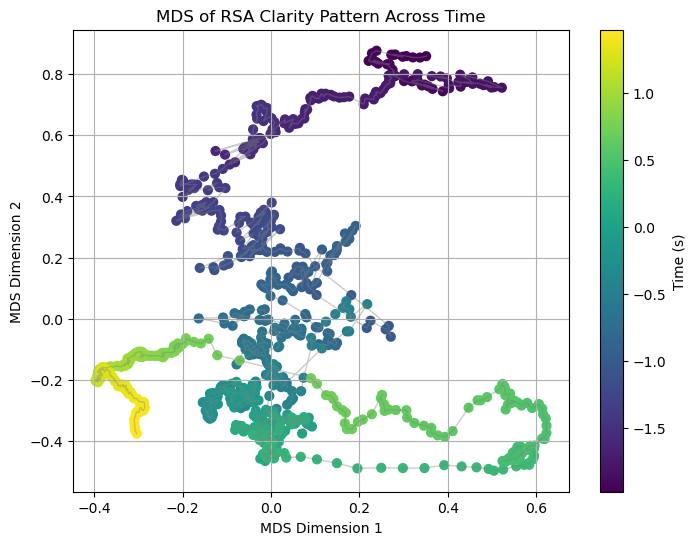

In [9]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Step 1: 轉置 RSA 矩陣（時間點為 row，subject 為 column）
rsa_clarity_by_time = rsa_clarity_allsubs.T  # shape = (n_timepoints, n_subjects)

# Step 2: 計算 timepoint × timepoint 的 dissimilarity 矩陣（使用 correlation-based）
# 每個 row 是一個時間點在所有 subject 的 RSA profile
dissimilarity_matrix = squareform(pdist(rsa_clarity_by_time, metric='correlation'))  # shape = (n_timepoints, n_timepoints)

# Step 3: 執行 MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dissimilarity_matrix)  # shape = (n_timepoints, 2)

# Step 4: 視覺化（以時間軸顏色標記點）
plt.figure(figsize=(8, 6))
sc = plt.scatter(coords[:, 0], coords[:, 1], c=time_centers, cmap='viridis', s=40)
plt.plot(coords[:, 0], coords[:, 1], color='gray', alpha=0.4, linewidth=1)
plt.colorbar(sc, label='Time (s)')
plt.title("MDS of RSA Clarity Pattern Across Time")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.show()